3. Group Proposed Project (10 marks)
3.1 At this point, you understand the data quite well. Carry out the analysis you proposed
in your group project proposal. You should use the dataset given but you may also use
additional datasets to supplement your analysis, look at unaggregated data, etc. Please
be sure to justify why the analysis is useful and interesting in the context of a data science
project. Note that you are not limited to the initial proposal and are free to expand on
it.
3.2 Based on the insights derived from the analysis, suggest a practical action that can be
taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as
hyperparameter tuning here).

In [63]:
import requests
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert to datetime iso
def toIso(dt):
    return datetime.fromisoformat(dt)

def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file): #check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir,is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year,'/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
                #create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file    
        df = pd.read_json(fDir)
        for heading in ("total_lots","lot_type","lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
        
        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df
    
    max_fail_count = 50
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)
    
    if not is_file_local: # If file doesn't exist, api call
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        
        #check if response is valid
        if response_API.ok and "items" in data and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
        else:
            error_count+=1
            print_api_error(year, month, day, hour, minute, second, error_count, data)
            if error_count<=max_fail_count:
                return carparkApiCall(year, month, day, hour, minute, second, error_count)
            else:
                f'Api call failed more than {max_fail_count} times :('
            
    df = read_from_file(fDir)
    return df

# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"]

def addDayHour(df, day, hour):
    df["day"] = day
    df["hour"] = hour
    return df

def removeCountTotal(df):
    df = df.drop(columns = ['lots_available', 'total_lots'])
    return df

In [11]:
# start date 1 Jan 2022 0001

year = 2022
month = 8
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
# total_hrs = 24*7*20 #24 hours, 7 days a week, 20 weeks
total_hrs = 1

data = None
# generate data
for hr in range(total_hrs):
    dt = dt + dt_interval
    try:
        data = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
    except:
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))

In [12]:
data.head()

,carpark_number,update_datetime,total_lots,lot_type,lots_available
0,HE12,2022-08-01 00:59:39,105,C,64
1,HLM,2022-08-01 00:59:33,583,C,503
2,RHM,2022-08-01 00:59:39,329,C,121
3,BM29,2022-08-01 00:59:50,97,C,84
4,Q81,2022-08-01 00:59:30,96,C,78


In [13]:
import csv
carpark_rates_dir = f'./data/hdb-carpark-information.csv'
df = pd.read_csv(carpark_rates_dir) 
df[["car_park_no","x_coord","y_coord"]]

,car_park_no,x_coord,y_coord
0,ACB,30314.7936,31490.4942
1,ACM,33758.4143,33695.5198
2,AH1,29257.7203,34500.3599
3,AK19,28185.4359,39012.6664
4,AK31,29482.0290,38684.1754
...,...,...,...
2177,Y77M,29850.1522,45576.0125
2178,Y78M,30057.2209,45166.4820
2179,Y8,27772.9219,45686.2734
2180,Y82M,29935.5818,45679.7181


In [14]:
carparks = set()
location = dict()
for index,row in df[["car_park_no","x_coord","y_coord"]].iterrows():
    carparks.add(row["car_park_no"])
    if row["car_park_no"] not in location:
        location[row["car_park_no"]] = [row["x_coord"],row["y_coord"]]
print(len(carparks),len(location))

2182 2182


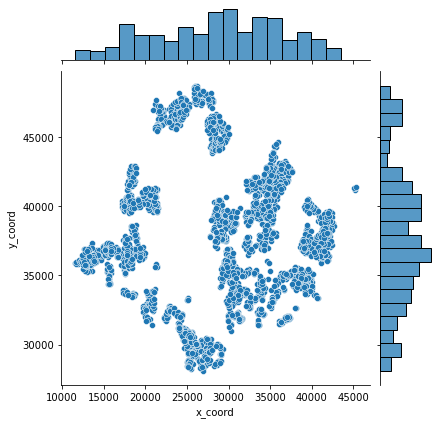

In [15]:
import seaborn as sns
sns.jointplot(data=df,x='x_coord',y='y_coord')

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

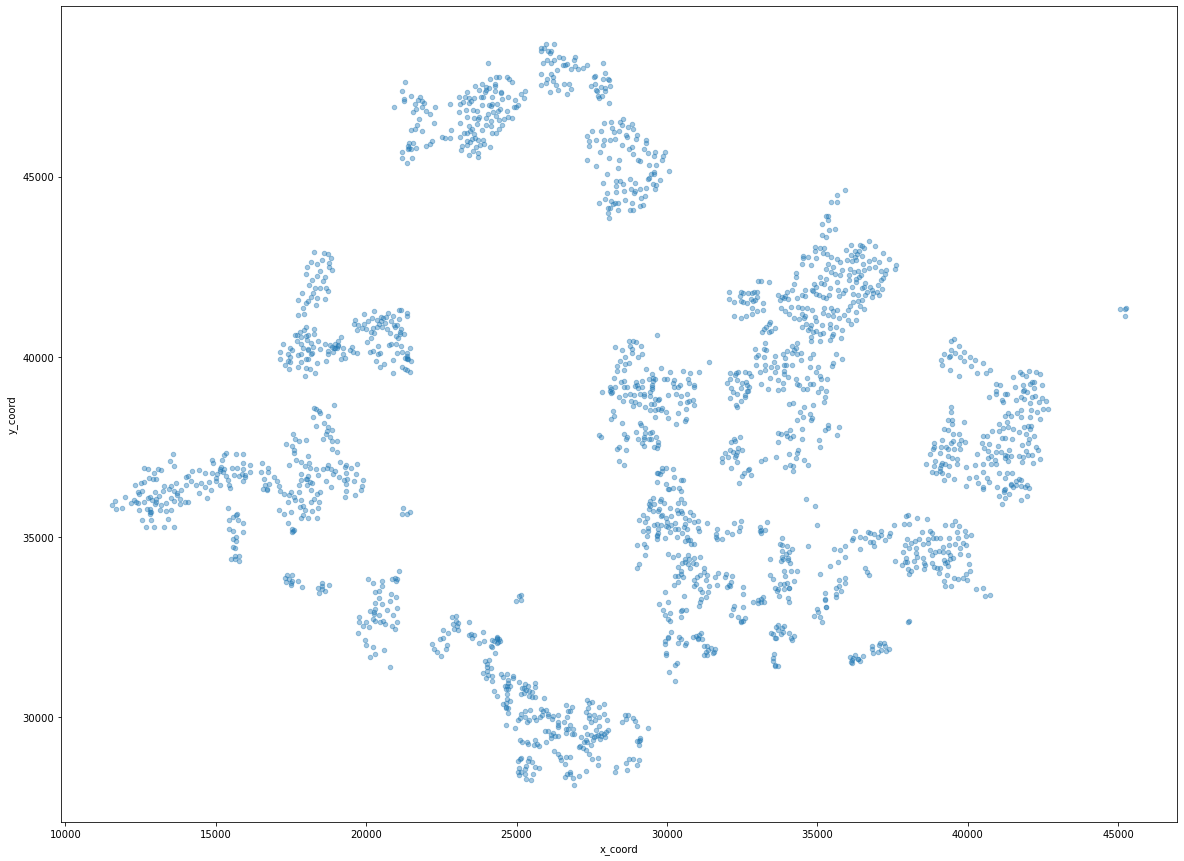

In [16]:
df.plot(x="x_coord",y="y_coord",kind="scatter",alpha=0.4,figsize=(20,15))

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[["x_coord_T","y_coord_T"]] = scaler.fit_transform(df[["x_coord","y_coord"]])

In [18]:
from sklearn.cluster import KMeans
def optimise_k_means(data,max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

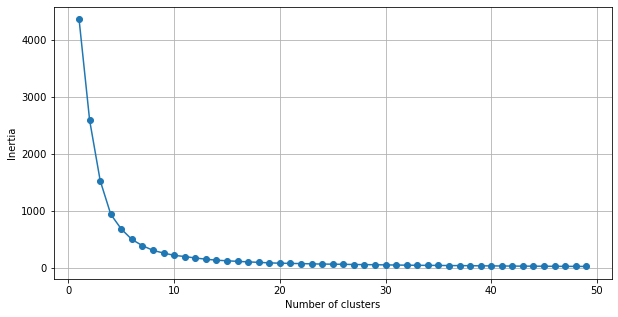

In [19]:
optimise_k_means(df[["x_coord_T","y_coord_T"]],50)

In [20]:
kmeans = KMeans(n_clusters=50)
kmeans.fit(df[["x_coord_T","y_coord_T"]])

KMeans(n_clusters=50)

In [21]:
df["kmeans"] = kmeans.labels_
df[["car_park_no","x_coord","y_coord","kmeans"]]

,car_park_no,x_coord,y_coord,kmeans
0,ACB,30314.7936,31490.4942,27
1,ACM,33758.4143,33695.5198,21
2,AH1,29257.7203,34500.3599,31
3,AK19,28185.4359,39012.6664,19
4,AK31,29482.0290,38684.1754,19
...,...,...,...,...
2177,Y77M,29850.1522,45576.0125,32
2178,Y78M,30057.2209,45166.4820,14
2179,Y8,27772.9219,45686.2734,32
2180,Y82M,29935.5818,45679.7181,32


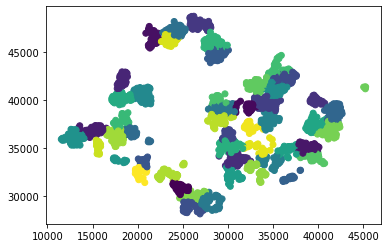

In [22]:
plt.scatter(x=df["x_coord"],y=df["y_coord"],c=df["kmeans"])
plt.show()

In [23]:
df = df[["car_park_no","x_coord","y_coord","kmeans"]]

In [24]:
def merge_on_col(df1,df2,col1,col2):
    return pd.merge(df1, df2, left_on=col1, right_on=col2, how='right').drop(col1, axis=1)

In [25]:
new_df = merge_on_col(df,data,"car_park_no","carpark_number")

In [26]:
new_df1 = new_df.groupby(["kmeans"])
new_df1.sum()

,x_coord,y_coord,total_lots,lots_available
kmeans,,,,
0.0,6.495827e+05,7.992137e+05,6165,2733
1.0,8.012378e+05,9.819566e+05,6348,2197
2.0,7.568656e+05,1.626577e+06,12688,3598
3.0,1.590608e+06,1.431715e+06,14197,6454
4.0,6.976000e+05,1.692160e+06,16471,6361
5.0,6.232787e+05,1.430447e+06,24492,15238
6.0,1.487060e+06,1.623332e+06,11677,4822
7.0,8.751081e+05,8.786305e+05,7770,2619
8.0,1.391739e+06,2.491092e+06,24890,13910


In [81]:
# start date 1 Jan 2022 0001

year = 2022
month = 1
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*7*20 #24 hours, 7 days a week, 20 weeks

# day of week,time of day
train_x = []
# avalibility percentage
train_y = []
# generate data, [day,month]
public_holidays = [[1,2], [2,2], [15,4], [2,5], [3,5], [3,16]]
for hr in range(total_hrs):
    dt = dt + dt_interval
    if [dt.day, dt.month] in public_holidays:
        print(f"{[dt.day, dt.month]} omitted as it is a public holiday on a weekday")
        continue
    try:
        apival = merge_on_col(df, carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0), "car_park_no", "carpark_number")
        apival = apival.groupby(["kmeans"]).sum().dropna(how='all')
        train_y.append(avrAvail(apival)) 
        train_x.append(addDayHour(removeCountTotal(apival), dt.weekday() , dt.hour))
        
    except Exception as e:
        print("exception occurred at")
        print(e)
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))

In [90]:
train_x

[             x_coord       y_coord  availability_percentage  day  hour
 kmeans                                                                
 0.0     6.495827e+05  7.992137e+05                 0.480718    5     1
 1.0     8.012378e+05  9.819566e+05                 0.347074    5     1
 2.0     7.568656e+05  1.626577e+06                 0.285883    5     1
 3.0     1.590608e+06  1.431715e+06                 0.417694    5     1
 4.0     6.976000e+05  1.692160e+06                 0.381427    5     1
 5.0     6.232787e+05  1.430447e+06                 0.644899    5     1
 6.0     1.487060e+06  1.623332e+06                 0.428828    5     1
 7.0     8.751081e+05  8.786305e+05                 0.368766    5     1
 8.0     1.391739e+06  2.491092e+06                 0.578930    5     1
 9.0     1.982704e+06  2.302355e+06                 0.424597    5     1
 10.0    7.496358e+05  9.074849e+05                 0.407360    5     1
 11.0    2.362543e+06  2.741775e+06                 0.473464    